# 1. Setup

In [1]:
import sys
sys.path.append('../..')
from mobiquity.names import *

# 2. Prepare data

## 2.1. Zones

In [2]:
indy_counties = ('Boone', 'Brown', 'Hamilton', 'Hancock', 'Hendricks', 'Johnson',
                 'Marion', 'Madison', 'Madison', 'Morgan', 'Shelby', 'Tipton')

In [3]:
zones = (
    U.load(DATA / 'zones/in_2020.parquet', columns=[
        'geoid', 'scale', 'county', 'aland', 'geometry'])
    .pipe(lambda df: df[df.county.isin(indy_counties)])
    .merge(U.load(DATA / 'ses/ses.parquet', columns=['geoid', 'popu']))
    .assign(pop_density=lambda df: df.popu / df.pop('aland'))
).disp()

1,918 rows x 6 cols; Memory: 0.3 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,county,geometry,popu,pop_density
,<object>,<category>,<category>,<geometry>,<float32>,<float32>
0,18011,County,Boone,"POLYGON ((-9613079.230266 4854909.530626, -961...",69839.0,165.150742


## 2.2. SES category

In [4]:
ses = U.load(DATA / 'ses/acs/acs_2021.parquet')
ses = zones[['geoid']].merge(ses)
ses['sedi'] = (ses[['p_poc', 'm_income', 'p_unemploy', 'p_renter', 'm_hhperveh']]
                .apply(lambda x: x.fillna(0).rank(pct=1)).mean(1))
ses['ses'] = pd.cut(ses.sedi, [-1, 0.33, 0.67, 1.1], labels=['High', 'Mid', 'Low'])
ses = ses[['geoid', 'sedi', 'ses']].disp()

1,918 rows x 3 cols; Memory: 0.1 MiB


,geoid,sedi,ses
,<object>,<float64>,<category>
0,18011,0.397445,Mid


## 2.3. Opportunities

In [5]:
opport = (U.load(DATA / 'access/opport/opportunities.parquet')
          .merge(zones['geoid'])).disp()

12,908 rows x 5 cols; Memory: 0.9 MiB


,geoid,scale,purpose,kind,opport
,<object>,<category>,<category>,<category>,<int32>
0,18011,County,Work,All,37858


## 2.4. Travel times

In [6]:
tt = (
    U.load(DATA / 'access/distances/gdm_2020.parquet',
           filters=[('scale', '==', 'BG')],
           columns=['mode', 'src', 'trg', 'time'])
    .merge(zones['geoid'].rename('src'))
    .merge(zones['geoid'].rename('trg'))
    .astype(D(src=CAT, trg=CAT))
    .assign(time=lambda df: df.time / 60)
    .query('time <= 90')
).disp()

2,974,963 rows x 4 cols; Memory: 48.5 MiB


,mode,src,trg,time
,<category>,<category>,<category>,<float32>
0,Transit,181095110022,181095110021,55.616665


### 2.4.1. Impedance function params
Taken from the results of `Function parameters.ipynb`.

In [7]:
params = (U.filt(U.load(DATA / 'impedance_params_single.csv'),
                func='Base exponential', target='Time', variable='β1')
          .query('factor != "Urbanity"').fillna('Overall')).disp(None)

10 rows x 3 cols; Memory: 0.0 MiB


,factor,level,value
,<object>,<object>,<float64>
0,Overall,Overall,0.053918
1,Mode,Drive,0.054819
2,Mode,Transit,0.019987
3,Mode,Walk,0.059946
4,Mode,Bike,0.045774
5,Purpose,Work,0.038162
6,Purpose,Non-work,0.057694
13,SES,Low,0.046369
14,SES,Mid,0.055596


## 2.5. Compute accessibility

In [8]:
def get_access_bg(opport=opport, tt=tt, ses=ses, params=params):
    beta0 = params.iloc[0].value
    opp_poi = U.filt(opport, purpose='Non-work')
    tt = tt.rename(columns=D(trg='geoid'))
    tt_drive = U.filt(tt, mode='Drive')
    def f(df, factor, level):
        beta = U.filt(params, factor=factor, level=level).iloc[0].value
        df['general'] = df.opport * np.exp(-beta0 * df.time)
        df['case'] = df.opport * np.exp(-beta * df.time)
        df = df.groupby('src')[['general', 'case']].sum().reset_index()
        return df.assign(factor=factor, level=level)
    res = []
    for mode, df in tt.groupby('mode'):
        res.append(f(df.merge(opp_poi), 'Mode', mode))
    for purp, df in opport.groupby('purpose'):
        res.append(f(tt_drive.merge(df), 'Purpose', purp))
    for ses_cat, df in ses.groupby('ses'):
        res.append(f(opp_poi.merge(df).merge(tt_drive), 'SES', ses_cat))
    df = pd.concat(res).rename(columns=D(src='geoid'))
    df['pct_diff'] = (df.general / (df.case + 1e-6) - 1) * 100
    df.factor, df.level = U.factor(df.factor), U.factor(df.level)
    return df

xs_bg = get_access_bg().disp() # 4s

12,834 rows x 6 cols; Memory: 0.6 MiB


,geoid,general,case,factor,level,pct_diff
,<category>,<float64>,<float64>,<category>,<category>,<float64>
0,180118101001,44.835234,64.116986,Mode,Bike,-30.072768


# 3. Visualize

## 3.1. SES category

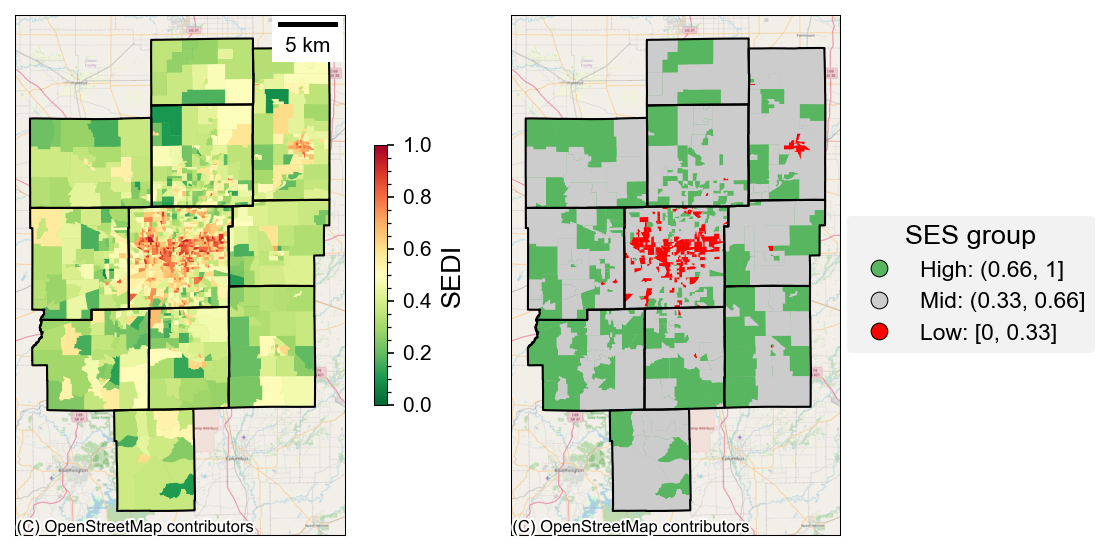

In [9]:
colors = D(High='#57B65F', Mid='#CCC', Low='r')
ses = zones.merge(ses.assign(color=ses.ses.map(colors)))
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), dpi=150,
                                gridspec_kw=D(width_ratios=[1, 0.8]))
U.maplot(ses, 'sedi', ax1, cmap='RdYlGn_r', vmin=0, vmax=1, label='SEDI')
ses.plot(ax=ax2, color=ses.color)
ctx.add_basemap(ax=ax2, crs=CRS_M, source=ctx.providers.OpenStreetMap.Mapnik)
ax2.set_xticks([]); ax2.set_yticks([])
ses_labels = ['High: (0.66, 1]', 'Mid: (0.33, 0.66]', 'Low: [0, 0.33]']
ax2.legend(loc=(1.02, 0.35), title='SES group', handles=[
    mpl.lines.Line2D([0], [0], label=x, color='none', marker='o',
                        markerfacecolor=c, markersize=8, markeredgewidth=0.5)
    for x, c in zip(ses_labels, colors.values())])
for ax in (ax1, ax2):
    zones.dissolve('county').plot(ax=ax, fc='none', ec='k')
plt.subplots_adjust(wspace=-0.05)
U.imsave('SEDI and SES groups of Indianapolis') # 5s

## 3.2. Access deviation

### 3.2.1. Comparison by variable

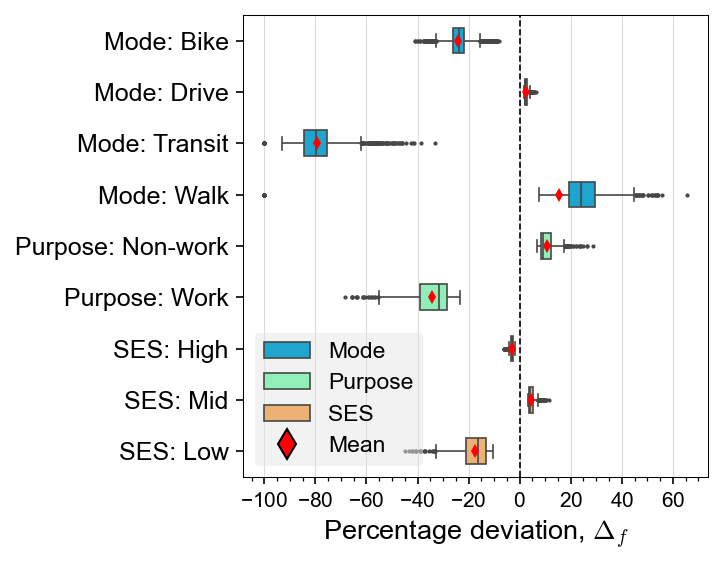

In [10]:
ax = U.plot(size=(4, 4), ylim=(-100, 50), dpi=150, yminor=0)
df = xs_bg.copy()
df['var'] = df.factor.astype(str) + ': ' + df.level.astype(str)
sns.boxplot(df, x='pct_diff', y='var', ax=ax, linewidth=0.8,
            width=0.5, fliersize=1, hue='factor', palette='rainbow',
            showmeans=True, meanprops=D(marker='d', markerfacecolor='r',
                                        markersize=5, markeredgecolor='none'))
ax.yaxis.set_tick_params(labelsize=12)
ax.axvline(0, ls='--', color='k', lw=0.8)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
ax.legend(handles=list(ax.legend().legend_handles) + [
    mpl.lines.Line2D([0], [0], color='none', label='Mean',
                     marker='d', markerfacecolor='r', markersize=10)
    ], title='', loc='lower left')
ax.set_xlabel('Percentage deviation, $\Delta_f$')
ax.set_ylabel('')
U.imsave('Access deviation by using generalized impedance function')

### 3.2.2. Map for work access and its deviation

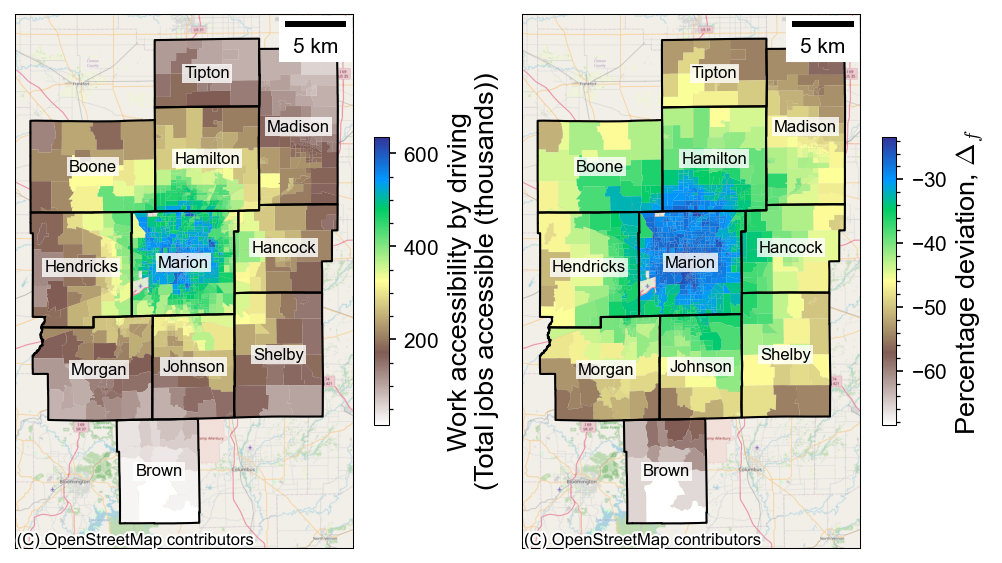

In [11]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), dpi=150)
df = U.filt(xs_bg, factor='Purpose', level='Work')
df = zones.merge(df)
df['general'] /= 1000
ax1 = U.maplot(df, 'general', ax1, cmap='terrain_r', label=\
    'Work accessibility by driving\n(Total jobs accessible (thousands))')
ax2 = U.maplot(df, 'pct_diff', ax2, cmap='terrain_r',
               label='Percentage deviation, $\Delta_f$')
cnty = zones[['county', 'geometry']].dissolve('county').dropna()
for ax in [ax1, ax2]:
    cnty.plot(ax=ax, fc='none', ec='k', lw=1)
    for _, r in cnty.iterrows():
        x, y = r.geometry.centroid.coords[0]
        ax.text(x, y, r.name, ha='center', va='center', fontsize=8,
                bbox=D(fc='w', alpha=0.8, pad=1, ec='none'))
U.imsave('Access and its deviation in Indianapolis')

### 3.2.3. For other variables

  0%|          | 0/9 [00:00<?, ?it/s]

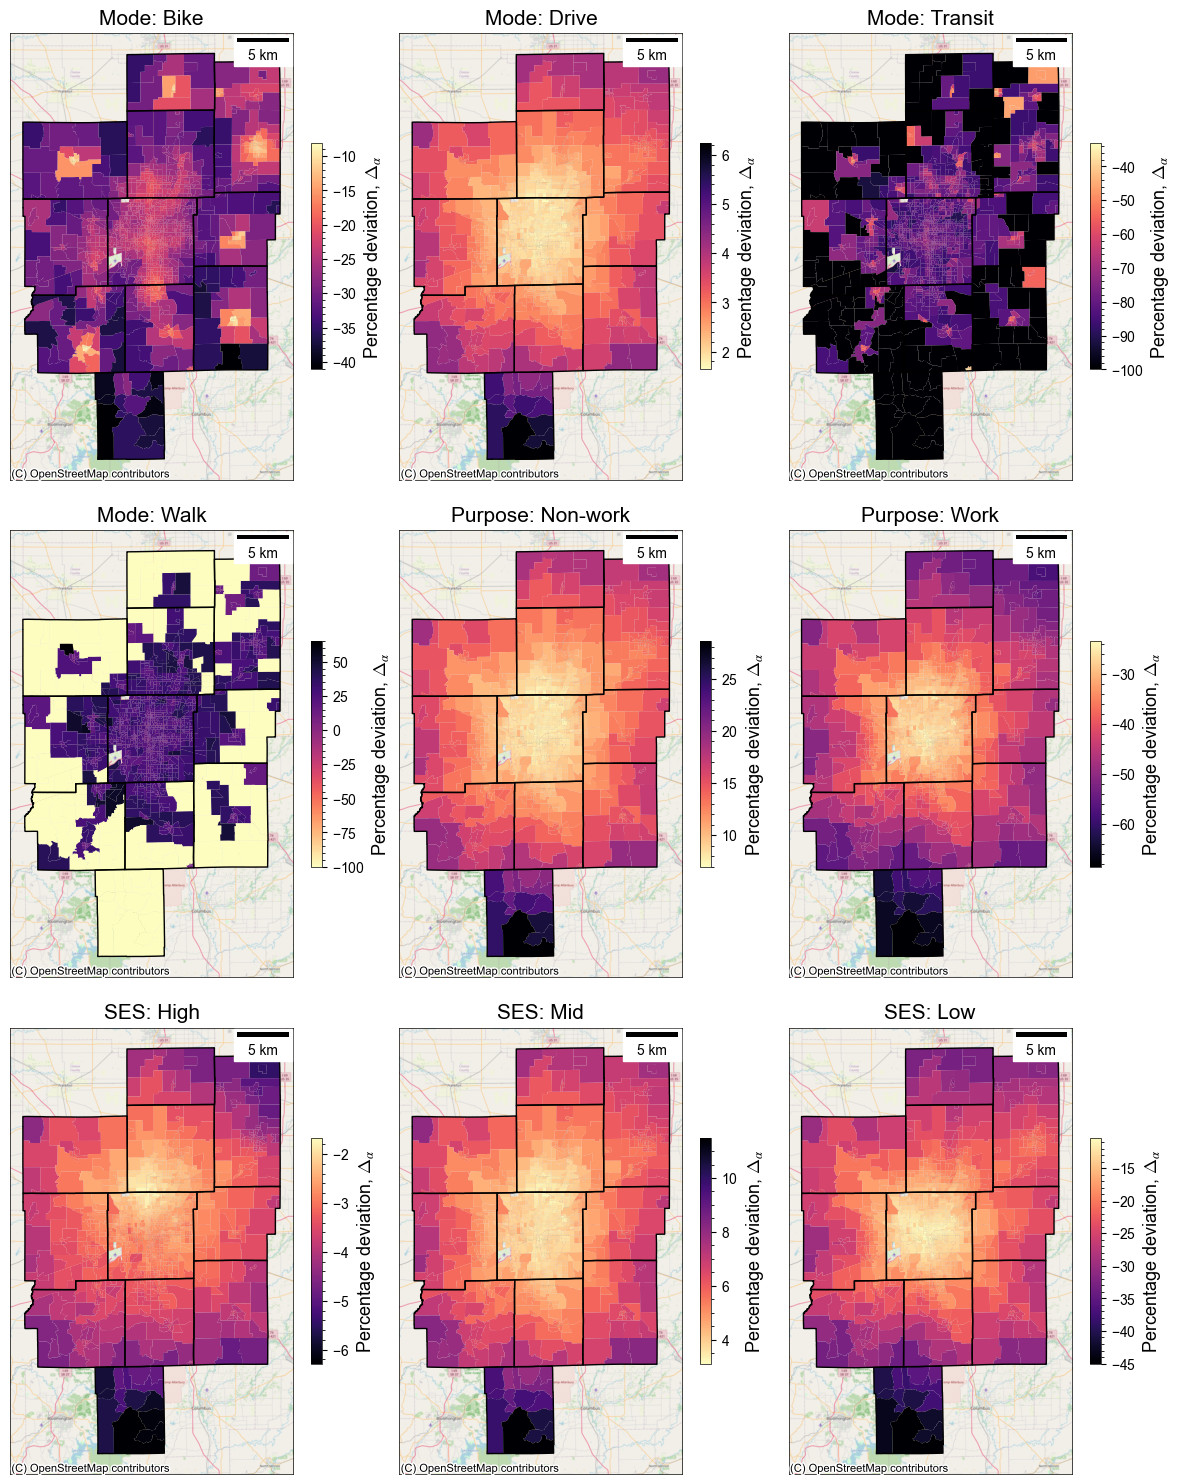

In [12]:
_, axes = plt.subplots(3, 3, figsize=(12, 15), dpi=100)
cnty = zones.dissolve('county')
for i, (level, df) in enumerate(tqdm(xs_bg.groupby('level'))):
    ax = U.plot(axes.flatten()[i], title=f'{df.factor.iloc[0]}: {level}')
    cmap2 = 'magma' + ('_r' if df.pct_diff.mean() > 0 else '')
    ax = U.maplot(zones.merge(df), 'pct_diff', ax, cmap=cmap2,
                    label='Percentage deviation, $\Delta_α$')
    cnty.plot(ax=ax, fc='none', ec='k', lw=1)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
U.imsave('Access deviation in Indianapolis by variable') # 24s